This notebook will look at the ellipses and the phase at the CODAR region.

In [189]:
import os
import datetime
import matplotlib.pylab as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Ellipse
import numpy as np
from IPython.display import display, Math, Latex
import csv
import pandas as pd
import subprocess as sp
from subprocess import Popen, PIPE
import matplotlib.colors as mcolors
import seaborn as sns
import math

import netCDF4 as nc
from salishsea_tools import viz_tools

%matplotlib inline

In [190]:
thalweg = np.loadtxt('/data/dlatorne/MEOPAR/tools/bathymetry/thalweg_working.txt', dtype=int, unpack=True)
grid = '/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc'
fB = nc.Dataset(grid)
bathy = fB.variables['Bathymetry'][:]
lons = fB.variables['nav_lon'][:]
lats = fB.variables['nav_lat'][:]

In [191]:
jmin = 379; jmax = 461; imin = 238; imax=321 
j = np.arange(jmin,jmax)
i = np.arange(imin,imax)

In [192]:
to = datetime.datetime(2014,11,26)
tf = datetime.datetime(2015, 7, 7)

t_o = to.strftime('%d%b%y').lower()
t_f = tf.strftime('%d%b%y').lower()

count = np.arange(0,16)
params_av = np.zeros((898,398,8))
q = 1
for x in i:
    for y in j:
        runname1 = '{}_{}_CODAR_{}_{}_surface(0-2m)'.format(t_o, t_f, x, y)
        f ='/ocean/mdunn/MEOPAR/analysis/Muriel/TidalEllipseData/CODAR/'+runname1+'.csv'
        if os.path.isfile(f)==True:
            df2 = pd.read_csv('/ocean/mdunn/MEOPAR/analysis/Muriel/TidalEllipseData/CODAR/'+runname1+'.csv', index_col=False)
            params_av[y, x,:] = df2.as_matrix()

In [193]:
##Masking the values 
params_av = np.ma.masked_values(params_av,0)

##Map of ellipses

red is clockwise


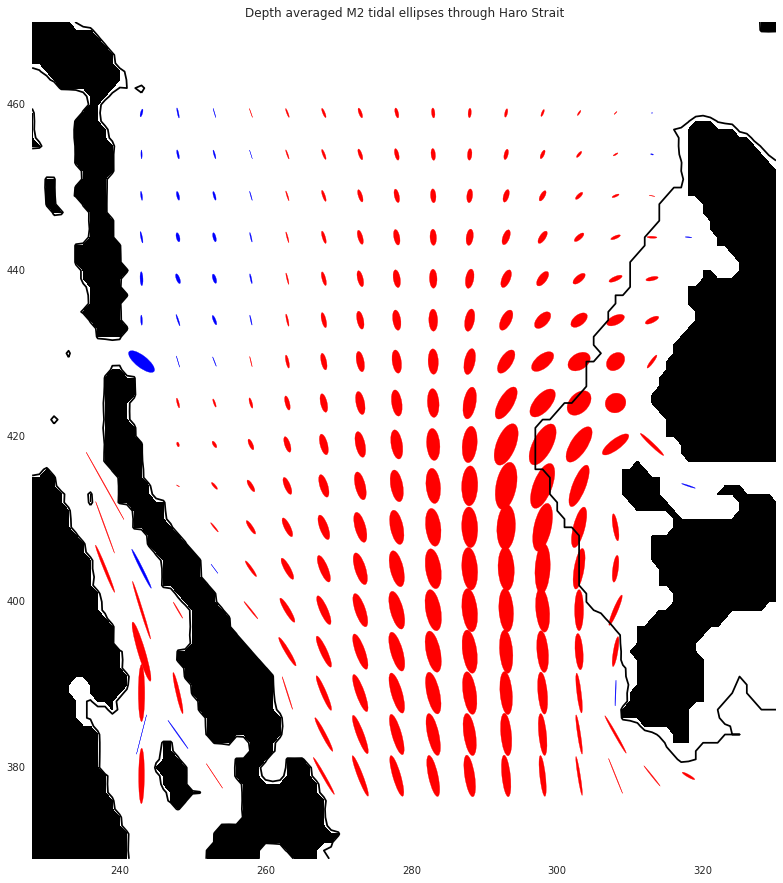

In [195]:
phi=0
fig = plt.figure(figsize=(20,15))
k = np.zeros((898,398)); m = np.zeros((898,398))
ax = fig.add_subplot(111)
viz_tools.set_aspect(ax) 
ex = 10
scale = 10

for q in np.arange(jmin-ex,jmax+ex):
    for l in np.arange(imin-ex,imax+ex):
        k[q,l] = q*np.cos(phi*np.pi/180.)+l*np.sin(phi*np.pi/180.)
        m[q,l] = -q*np.sin(phi*np.pi/180.)+l*np.cos(phi*np.pi/180.) 

for x in i:
    for y in j:
        if params_av[y,x,1] > 0:
            thec = 'b'
        else:
            thec = 'r'
        ellsc = Ellipse(xy=(m[y,x],k[y,x]), width=scale*params_av[y,x,0], 
                            height=scale*params_av[y,x,1], angle=params_av[y,x,2]-29,
                            color=thec)
        ax.add_artist(ellsc)
        ellsc.set_facecolor(thec)

contour_interval = [-0.01, 0.01]
ax.contourf(m[jmin-ex:jmax+ex,imin-ex:imax+ex],k[jmin-ex:jmax+ex,imin-ex:imax+ex],
        bathy.data[jmin-ex:jmax+ex,imin-ex:imax+ex],contour_interval,colors='black')
ax.contour(m[jmin-ex:jmax+ex,imin-ex:imax+ex],k[jmin-ex:jmax+ex,imin-ex:imax+ex],
            bathy.data[jmin-ex:jmax+ex,imin-ex:imax+ex],[5],colors='black')
ax.set_title('Depth averaged M2 tidal ellipses through Haro Strait')

print "red is clockwise"

#Phase plot

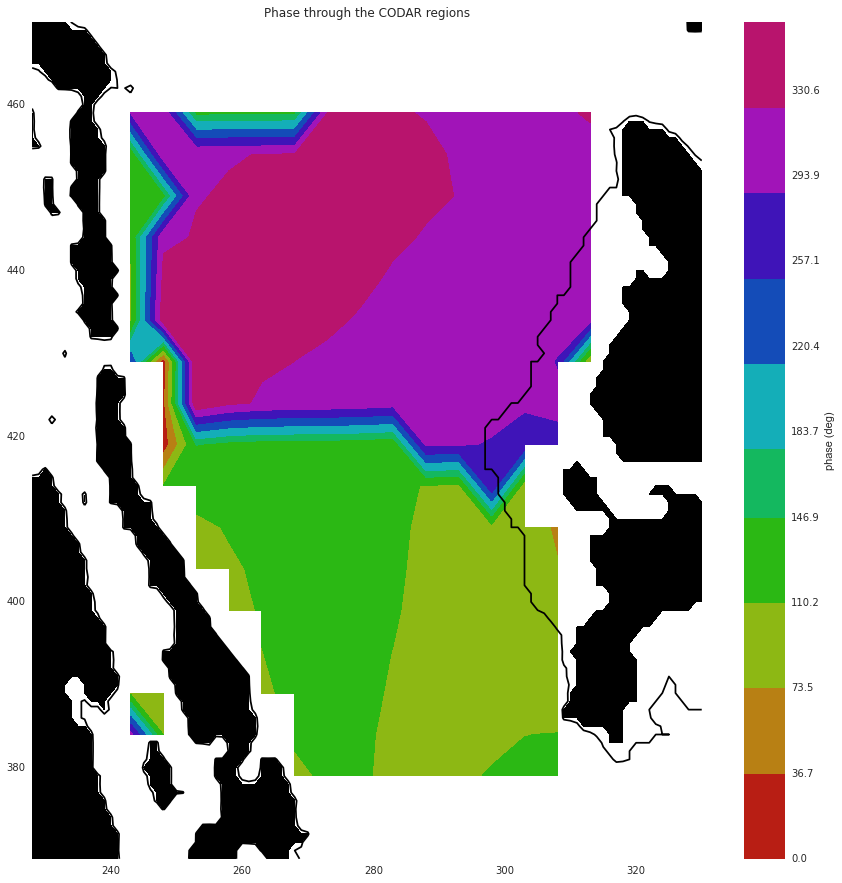

In [174]:
vals = params_av[jmin:jmax:5, imin:imax:5, 3]

x = np.arange(imin,imax,5)
y = np.arange(jmin, jmax,5)

vs= np.linspace(0,360)
# combine them and build a new colormap
colors = np.vstack((pos, neg))
palette = sns.hls_palette(10, l=.4, s=0.8)
cmap1 = mcolors.ListedColormap(palette)


fig, ax = plt.subplots(1,1, figsize=(15,15))
cbar = plt.colorbar
mesh = ax.contourf(x, y, vals, vs, cmap=cmap1)

ax.contourf(m[jmin-ex:jmax+ex,imin-ex:imax+ex],k[jmin-ex:jmax+ex,imin-ex:imax+ex],
        bathy.data[jmin-ex:jmax+ex,imin-ex:imax+ex],contour_interval,colors='black')
ax.contour(m[jmin-ex:jmax+ex,imin-ex:imax+ex],k[jmin-ex:jmax+ex,imin-ex:imax+ex],
            bathy.data[jmin-ex:jmax+ex,imin-ex:imax+ex],[5],colors='black')
cbar = fig.colorbar(mesh)
cbar.set_label('phase (deg)')
ax.set_title('Phase through the CODAR regions')